In [45]:
# выделение признаков временного ряда

In [46]:
# импорт
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [47]:
# получение данных 
# (так как они копируют получение данных в 2, то загрузим сохраненный обработанный датасет)
df_rename = pd.read_csv('../data/gdelt_counts_event_by_day_clear.csv', index_col='date', parse_dates=['date']);

In [48]:
# лаги по времени

# разделяем на лаги одно из свойств, например 'EXHIBIT FORCE POSTURE'
data = pd.DataFrame()

for i in range(6, 45):
    data["lag_{}".format(i)] = df_rename['EXHIBIT FORCE POSTURE'].shift(i)

data['y'] = df_rename['EXHIBIT FORCE POSTURE']

In [49]:
data.tail()

lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
date                                                                     
2019-12-27  244.0  417.0  377.0  472.0   433.0   402.0   234.0   273.0   
2019-12-28  221.0  244.0  417.0  377.0   472.0   433.0   402.0   234.0   
2019-12-29  330.0  221.0  244.0  417.0   377.0   472.0   433.0   402.0   
2019-12-30  316.0  330.0  221.0  244.0   417.0   377.0   472.0   433.0   
2019-12-31  254.0  316.0  330.0  221.0   244.0   417.0   377.0   472.0   

            lag_14  lag_15  ...  lag_36  lag_37  lag_38  lag_39  lag_40  \
date                        ...                                           
2019-12-27   374.0   469.0  ...   309.0   467.0   521.0   490.0   309.0   
2019-12-28   273.0   374.0  ...   355.0   309.0   467.0   521.0   490.0   
2019-12-29   234.0   273.0  ...   309.0   355.0   309.0   467.0   521.0   
2019-12-30   402.0   234.0  ...   281.0   309.0   355.0   309.0   467.0   
2019-12-31   433.0   402.0  ...   379.0   281.0   309.0   355.0   309.0   

            lag_41  lag_42  lag_43  lag_44      y  
date                                               
2019-12-27   296.0   404.0   414.0   461.0  442.0  
2019-12-28   309.0   296.0   404.0   414.0  260.0  
2019-12-29   490.0   309.0   296.0   404.0  301.0  
2019-12-30   521.0   490.0   309.0   296.0  431.0  
2019-12-31   467.0   521.0   490.0   309.0  476.0  

[5 rows x 40 columns]

In [50]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# строим наши выборки
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

tscv = TimeSeriesSplit(n_splits=5)

In [51]:
#определим ряд удобных функций из https://mlcourse.ai/articles/topic9-part1-time-series/
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [52]:
# обучаем регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

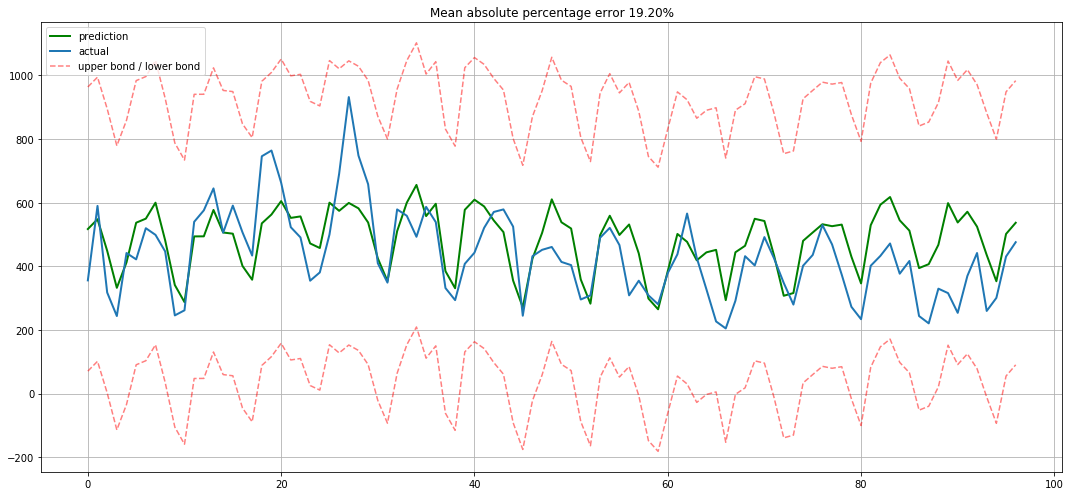

In [53]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [54]:
# первом графике можно заметить как сходится предсказание с реальным результатом
# на втором можно увидеть наиболее значимые отступы

# 21, 44, 7, 35 - являются наиболее значимыми отступами по дням